In [1]:
import numpy as np
import random
import time

In [2]:
import sys
import os

In [3]:
import swyft
import torch
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
import wandb

In [4]:
import matplotlib
import matplotlib.pyplot as plt

In [5]:
import IPython

In [6]:
import pickle

In [7]:
%matplotlib inline

In [8]:
files_name = "all_v2" + "_files"
parent_dir = (os.getcwd()+"/").split('/notebooks/', 1)[0]
start_dir = os.getcwd()
files_dir = os.getcwd() + "/" + files_name 
store_name = files_name.split("_files")[0] + "_store"
store_dir = os.getcwd() + "/" + files_name + "/" + store_name
sys.path.append(files_dir)

In [9]:
from ALP_quick_sim import ALP_sim

In [10]:
with open(files_dir+"/"+'config_objects.pickle', 'rb') as file:
    config_objects = pickle.load(file)
for key in config_objects.keys():
    locals()[key] = config_objects[key]

with open(files_dir+"/"+'obs_objects.pickle', 'rb') as file:
    obs_objects = pickle.load(file) 
for key in obs_objects.keys():
    locals()[key] = obs_objects[key]

with open(files_dir+"/"+'sim_objects.pickle', 'rb') as file:
    sim_objects = pickle.load(file)
for key in sim_objects.keys():
    locals()[key] = sim_objects[key]

In [11]:
marginals = [0]

# Load simulations again

In [12]:
store = swyft.ZarrStore(store_dir + "/" + store_name)
samples = store.get_sample_store()

In [13]:
len(samples)

200000

In [14]:
np.where(np.isinf(samples['data']))

(array([], dtype=int64), array([], dtype=int64))

In [15]:
inf_sims = np.where(np.isinf(samples['data']))
for i,inf_sim in enumerate(inf_sims[0]):
    samples['data'][inf_sim,inf_sims[1][i]] = samples['data'][inf_sim,inf_sims[1][i]-1]

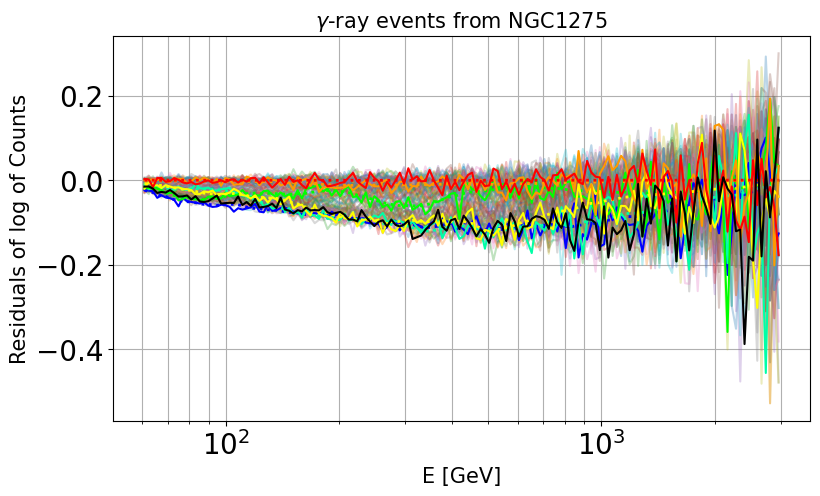

In [16]:
A.configure_plot(xmin=None, xmax=None, ymin=None,ymax=None,legend=0, logx=1, logy=0)
for i in range(min(len(samples),100)):
    A.configure_model(params=samples[i]['params'])
    A.import_counts(obs=samples[i]['data'],exp=samples[i]['exp'])
    new_fig = 1 if i==0 else 0
    A.compute_case(new_fig=new_fig,new_counts=0,color=None,color_obs=None,linestyle="-",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_exp=0, transparency=0.7)


for i,obs in enumerate(observations):
    A.configure_model(params=obs['params'])
    A.import_counts(obs=obs['data'],exp=obs['exp'])
    shade = i/(len(observations)+1)
    A.compute_case(new_fig=0,new_counts=0,color='k',color_obs=colors[i],linestyle_obs="-",label_exp=0,label_obs=0,
                   errorbands=0, errors=0, plot_exp=0)
    A.compute_case(new_fig=0,new_counts=0,color=colors[i],color_obs=colors[i],linestyle=":",label_exp=0,label_obs=0,
                        errorbands=0, errors=0, plot_obs=0) 

A.import_counts(obs=samples['data'][96761,:],exp=samples['exp'][96761,:])
A.compute_case(new_fig=0,new_counts=0,color='k',color_obs='k',linestyle_obs="-",label_exp=0,label_obs=0,
               errorbands=0, errors=0, plot_exp=0)

# Train again

In [17]:
class Network(swyft.AdamWReduceLROnPlateau,swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        
        self.norm_data = swyft.networks.OnlineStandardizingLayer(torch.Size([A.nbins]), epsilon=0)
        #self.norm_ft = swyft.networks.OnlineStandardizingLayer(torch.Size([len_fts]), epsilon=0)
        
        self.learning_rate = 5e-2
        
        # self.net_data = torch.nn.Sequential(
        #     torch.nn.Flatten(),
        #     torch.nn.Linear(A.nbins,256),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(256,256),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(256,4)
        # )

        # self.net_FT = torch.nn.Sequential(
        #     torch.nn.Flatten(),
        #     torch.nn.Linear(A.nbins,256),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(256,256),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(256,4)
        # )


        self.net_data = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.LazyLinear(256),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(256),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(4)
        )

        self.net_ft = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.LazyLinear(128),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(128),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(4)
        )

  
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features = 4, 
            num_params = len(marginals), 
            varnames = sim.A.param_names)
        
        #self.learning_rate = 0.000005
    
    def forward(self, A, B):
        data = self.norm_data(A['data'])
        #ft = data
        data = self.net_data(data)
        #ft = torch.tensor(FT(A['data']))
        #ft = self.norm_ft(ft)
        #ft = self.net_ft(ft)

        #final_features = torch.cat((data,ft), axis = 1)
        
        return self.logratios(data, B['params'][:,marginals])

In [18]:
network = Network()

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
wandb_logger = WandbLogger(log_model='all')

wandb: Currently logged in as: gertwkl (alps_with_swyft). Use `wandb login --relogin` to force relogin


In [20]:
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = swyft.SwyftTrainer(
    accelerator = 'cpu', precision = 64, logger=wandb_logger, # min_epochs =25,
    callbacks = [lr_monitor], log_every_n_steps=10,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
dm = swyft.SwyftDataModule(samples, num_workers = 6, batch_size=int(2**14), 
                           on_after_load_sample = sim.get_resampler(targets = ['data']), )

In [22]:
trainer.fit(network, dm)

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:411: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name      | Type                     | Params
-------------------------------------------------------
0 | norm_data | OnlineStandardizingLayer | 0     
1 | net_data  | Sequential               | 0     
2 | net_ft    | Sequential               | 0     
3 | logratios | LogRatioEstimator_1dim   | 17.6 K
-----------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: ./lightning_logs/pqbdcpcd/checkpoints/epoch=11-step=120.ckpt


In [23]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
lr-AdamW,████████████████▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,██▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,16
lr-AdamW,0.005
train_loss,0.00025
trainer/global_step,169
val_loss,0.00012


In [24]:
torch.save(network.state_dict(),'trained_network_'+ipynbname.name()+'.pt')

NameError: name 'ipynbname' is not defined

# Infer again

In [ ]:
prior_samples = sim.sample(100_000, targets=['params'])

In [ ]:
for j in range(len(truths)):
    logratios = trainer.infer(
                            network,
                            observations[j],
                            prior_samples
                            )
    
    # swyft.plot_posterior(logratios, A.param_names, truth={A.param_names[i]:truths[j][i] for i in range(len(truths[j]))})
    swyft.plot_posterior(logratios, A.param_names[0], truth={A.param_names[i]:truths[j][i] for i in range(1)}, color_truth=colors[j])

In [ ]:
new_net = Network()
new_net.load_state_dict(torch.load('trained_network_'+ipynbname.name()+'.pt'))

In [ ]:
for j in range(len(truths)):
    logratios = trainer.infer(
                            new_net,
                            observations[j],
                            prior_samples
                            )
    
    # swyft.plot_posterior(logratios, A.param_names, truth={A.param_names[i]:truths[j][i] for i in range(len(truths[j]))})
    swyft.plot_posterior(logratios, A.param_names[0], truth={A.param_names[i]:truths[j][i] for i in range(1)}, color_truth=colors[j])